In [3]:
import json
from fitbit_api import fitbit, gather_keys_oauth2 as Oauth2

keys = json.loads(open('keys.json').read())

CLIENT_ID = keys['CLIENT_ID']
CLIENT_SECRET = keys['CLIENT_SECRET']
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()

ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])


[12/Mar/2019:19:07:24] ENGINE Listening for SIGTERM.
[12/Mar/2019:19:07:24] ENGINE Listening for SIGHUP.
[12/Mar/2019:19:07:24] ENGINE Listening for SIGUSR1.
[12/Mar/2019:19:07:24] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[12/Mar/2019:19:07:24] ENGINE Started monitor thread 'Autoreloader'.
[12/Mar/2019:19:07:24] ENGINE Serving on http://127.0.0.1:8080
[12/Mar/2019:19:07:24] ENGINE Bus STARTED


127.0.0.1 - - [12/Mar/2019:19:07:26] "GET /?code=704010de8ac3ac2dec9cf6b3d3cf86ff8424c2a5&state=cl9X5k3PVzYUS06LpvG9p9S6LTaxef HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36"


[12/Mar/2019:19:07:27] ENGINE Bus STOPPING
[12/Mar/2019:19:07:32] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[12/Mar/2019:19:07:32] ENGINE Stopped thread 'Autoreloader'.
[12/Mar/2019:19:07:32] ENGINE Bus STOPPED
[12/Mar/2019:19:07:32] ENGINE Bus EXITING
[12/Mar/2019:19:07:32] ENGINE Bus EXITED
[12/Mar/2019:19:07:32] ENGINE Waiting for child threads to terminate...


In [4]:
client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)


In [5]:
import pandas as pd
from datetime import datetime, timedelta

def datetime_str_to_object(fitbit_str):
    """Helper function to convert fitbit datetime str into python datetime object"""
    return datetime.strptime(fitbit_str, "%Y-%m-%dT%H:%M:%S.000")

def normalize_fall_asleep(df, date):
    """Helper function to reset index of fall asleep times into duration of sleep"""
    # instead of 12:07 it will be 0 minutes from falling asleep
    df = df.reset_index() # remove time index
    # df['time'] = date+"T"+df['time']+".000" # create datetime str format
    # df['time'] = df['time'].apply(lambda x: datetime_str_to_object(x)) # concert str times into datetime objects
    # df['time'] = df['time'] - df['time'][0] # subtract start time from the actual time
    # df['time'] = df['time'].apply(lambda x: int(x.total_seconds()//60)) # convert into minutes
    # NO NEED FOR ALL THE CONVERSIONS SINCE reset_index GIVES THE VALUES OF THE MINUTES PASSED
    df['time'] = df.index # minutes after falling asleep
    df = df.set_index('time')
    return df

def get_heart_rate(date): # date is a string of format 'yyyy-mm-dd'
    """Returns the heart rate data(with index of time) based on the given date"""
    values, times = [], []
    heart_rate_json = client.intraday_time_series("activities/heart", base_date=date, detail_level="1min")
    
    for item in heart_rate_json['activities-heart-intraday']['dataset']:
        values.append(item['value'])
        times.append(item['time'])

    return pd.DataFrame({'heart_rate':values,'time':times}).set_index('time')

def get_sleep_data(date): # date is a string of format 'yyyy-mm-dd'
    """Returns the sleep data dictionary of {start_time, end_time, awake_times}"""
    awake_times = []
    sleep = client.sleep(date)
    
    for item in sleep['sleep'][0]['minuteData']:
        if item['value']=='2':
            awake_times.append(item['dateTime'])
    
    start_time = datetime_str_to_object(sleep['sleep'][0]['startTime']).strftime("%H:%M:%S")
    end_time = datetime_str_to_object(sleep['sleep'][0]['endTime']).strftime("%H:%M:%S")
    
    return {"start_time":start_time, "end_time": end_time, "awake_times":awake_times}

def get_sleep_heart_rate(date): # date is a string of format 'yyyy-mm-dd'
    """Returns the pandas df of {minutes_asleep, heart_rate, is_awake(1 or 0)}"""
    sleep_dict = get_sleep_data(date) # get sleep dictionary of start,end and awake times
    sleep_df = get_heart_rate(date).loc[sleep_dict['start_time']:sleep_dict['end_time']] # select only sleep heart_rates
    sleep_df['is_awake'] = 0 # is_awake value 0 by default
    sleep_df['is_awake'].loc[sleep_dict['awake_times']] = 1 # add is_awake values
    sleep_df = normalize_fall_asleep(sleep_df, date)
    
    return sleep_df

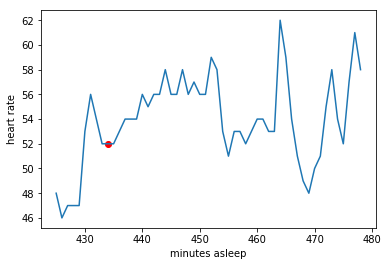

In [24]:
import matplotlib.pyplot as plt

date = "2019-03-12"

df = get_sleep_heart_rate(date) # .loc[425:] for more specific times

plt.ylabel('heart rate')
plt.xlabel('minutes asleep')
plt.plot(list(df.index),df['heart_rate'])

# mark awakes with red dot
plt.scatter(list(df.loc[df['is_awake']==1].index),df['heart_rate'].loc[df['is_awake']==1], c='r')

plt.show()